<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Lab_9_(Deep_RL_PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

In [0]:
!pip3 install gym torch torchvision tqdm
!pip install box2d-py
!pip install gym[Box_2D] 
!pip install gym[atari]

    100% |████████████████████████████████| 1.5MB 15.6MB/s 
    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6123c000 @  0x7f0a04a582a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 22.6MB/s 
    100% |████████████████████████████████| 1.0MB 4.5MB/s 
    100% |████████████████████████████████| 2.0MB 4.5MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 450kB

In [0]:
# Standard pytorch and math imports
import torch
from torch import nn 
from torch import optim
from torch.utils.data import Dataset, DataLoader

import seaborn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Specific or new to this lab
import gym
from itertools import chain # convenient way to tell Adam what to backprop on

# Code Pieces

## Policy and value networks

In [0]:
class ValueNetwork(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim=100):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )

    def forward(self, x):
        return self.net(x)
    
class PolicyNetwork(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim=100):
        super(PolicyNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, get_action=False):
        """
        Arguments
        ---------
        x of shape [batch, state_dim]
        
        Output a probability distribution over actions and a sampled action.
        """
        
        scores = self.net(x)
        probs = self.softmax(scores)
        
        if get_action == False:
            return probs
        
        n_batch = x.shape[0]
        p = probs.cpu().detach().numpy()
        samples = [np.random.choice(p.shape[1], p=p[i]) for i in range(n_batch)]
        
        return probs, np.array(samples, dtype=np.uint8).reshape((n_batch, 1))

## Environment wrapper class

In [0]:
class OpenAIGymEnvironment(object):
    def __init__(self, name):
        super(OpenAIGymEnvironment, self).__init__()
        self.environment = gym.make(name)
        
        self.num_actions = self.environment.action_space.n
        self.environment.reset()
        s, r, t, _ = self.environment.step(np.random.randint(self.num_actions))
        self.state_dims = len(s)

    def step(self, action):
        """
        Takes an action x which is the same format as the output from a policy 
        network; action is a numpy array of shape [1] and type np.uint8. 
        """
        s, r, t, _ = self.environment.step(action.item())
        return s, r, t

    def reset(self):
        """Returns observation (numpy array)"""
        return self.environment.reset()

## Experience dataset collector

In [0]:
class ExperienceDataset(Dataset):
    
    def __init__(self, environment, embedding_net, policy_net, num_trials, 
                 max_trial_length, gamma):
        
        super(ExperienceDataset, self).__init__()
        
        self.policy_net = policy_net
        self.embedding_net = embedding_net
        self.max_trial_length = max_trial_length
        self.gamma = gamma
        
        self.experiences = []
        self.rewards = []
        
        self.avg_len = 0
        for trial in range(num_trials):
            trial_len = self.run_trial(environment)
            self.avg_len += 0.01*trial_len    
            
        self.mean_reward = np.mean(self.rewards)
        
    def run_trial(self, environment):
        
        current_trial = []
        current_env = environment.reset()
        trial_reward = 0
        hit_max_length = 0
        
        for turn in range(self.max_trial_length):
            
            # Collect (and embed) the input state in correct format
            input_state = torch.from_numpy(current_env).float().unsqueeze(0)
            if self.embedding_net:
                input_state = self.embedding_net(input_state)
            
            # Choose an action using the policy and step the environment forward
            a_dist, action = self.policy_net(input_state, True)
            next_environment, reward, finished = environment.step(action[0])
   
            # Store and keep track of things
            current_trial.append((current_env, a_dist[0].cpu().detach().numpy(), 
                                  action[0], reward))
            trial_reward += reward
            current_env = next_environment
            
            # Check if the trial finished early
            if finished:
                break
         
        # Calculate returns
        current_return = 0
        for i in reversed(range(len(current_trial))):
            s, a_dist, a, reward = current_trial[i]
            current_return = reward + self.gamma * current_return
            current_trial[i] = (s, a_dist, a, reward, current_return)
            
        self.experiences.extend(current_trial)
        self.rewards.append(trial_reward) # just for reporting in loop
        
        return len(current_trial)
        
    def __getitem__(self, index):
        return self.experiences[index]

    def __len__(self):
        return len(self.experiences)

## PPO experiment wrapper


In [0]:
def likelihood(action_distribution, actions):
    """
    What probability of choosing the actions chosen did we have?
    Batch dimension is 0 so we gather on dimension 1
    """
    return torch.gather(action_distribution, 1, actions.long())
    
def ppo(environment, policy_net, value_net, likelihood_fn, avg_rewards,
        solved_reward, embedding_net=None, epochs=1000, policy_epochs=5,
        batch_size=256, trials_per_epoch=100, max_trial_length=200):
    
    gamma = 0.99
    eps = 0.1
    lr = 1e-3
    betas = (0.9, 0.999)
    weight_decay = 0.01
    
    # Collect parameters and tell Adam what to optimize with respect to
    params = chain(policy_net.parameters(), value_net.parameters())
    if embedding_net:
        params = chain(params, embedding_net.parameters())
    optimizer = optim.Adam(params, lr=lr, betas=betas, weight_decay=weight_decay)
    
    value_criteria = nn.MSELoss()
    loop = tqdm(total=epochs, position=0, leave=False)

    for epoch in range(epochs):
        
        # Get some experiences and put them in a DataLoader
        experiences = ExperienceDataset(environment, embedding_net, policy_net, 
                                      trials_per_epoch, max_trial_length, gamma)
        data_loader = DataLoader(experiences, batch_size=batch_size, 
                                 shuffle=True, pin_memory=True)
        avg_rewards.append(experiences.mean_reward)
        
        # If avg reward over last 5 epochs > solved, we win and can stop
        recent_avg = np.mean(avg_rewards[max(-5,-len(avg_rewards)):])
        if recent_avg > solved_reward:
            break
        
        # Train policy and value estimation functions based on recent experience
        for policy_epoch in range(policy_epochs):
                
            avg_policy_loss = 0
            avg_val_loss = 0
            
            for state, action_dist, action, reward, return_ in data_loader:
                
                # Tbh we should probably just detach these when we store them
                state = state.detach().float()
                action_dist.detach().float()
                action = action.detach().float()
                return_ = return_.detach().float().unsqueeze(1)
                
                if embedding_net:
                    state = embedding_net(state)
                
                optimizer.zero_grad()
                
                # Compare likelihood of a new action under old and new dist
                new_action_dist = policy_net(state, False)
                current_likelihood = likelihood_fn(new_action_dist, action)
                old_likelihood = likelihood_fn(action_dist, action)
                r_t = current_likelihood / old_likelihood

                # Compare expected value of state to actual return for val_loss
                expected_returns = value_net(state)
                val_loss = value_criteria(expected_returns, return_) # just MSE
                
                # Advantage of observed return compared to estimated return 
                A_t = return_ - expected_returns.detach()
                
                # Policy loss as in paper
                policy_loss = -torch.mean(torch.min(r_t*A_t,
                                          torch.clamp(r_t, 1-eps, 1+eps) * A_t))
                
                # Backpropagate
                loss = policy_loss + val_loss
                loss.backward()
                optimizer.step()
                
                # Just for keeping track
                avg_val_loss += val_loss.item()
                avg_policy_loss += policy_loss.item()
            
            # Display average results over policy epoch in tqdm loop
            avg_val_loss /= len(data_loader)
            avg_policy_loss /= len(data_loader)
            loop.set_description(
            'Reward: %.2f, losses: value %.2f, policy %.2f, avg_len %.0f, recent avg %.2f' % 
            (experiences.mean_reward, avg_val_loss, avg_policy_loss, 
             experiences.avg_len, recent_avg)
            )
            
        # Crude way to keep track of progress as we iterate
        if epoch % 10 == 1:
            print() 
            
        loop.update(1)

## Function to run PPO for any discrete OpenAIGym environment

In [0]:
def run_discrete(environment_name, solved_reward, max_trial_length, avg_rewards,
                num_rollouts=100, hidden_dims=25):
    
    environment = OpenAIGymEnvironment(environment_name)
    embedding = nn.Sequential(nn.Linear(environment.state_dims, 100), nn.ReLU(), 
                              nn.Linear(100, 100), nn.ReLU())
    policy = PolicyNetwork(100, environment.num_actions, hidden_dim=hidden_dims)
    value = ValueNetwork(100, 1, hidden_dim=hidden_dims)

    ppo(environment, policy, value, likelihood, avg_rewards, solved_reward, 
        embedding_net=embedding, max_trial_length=max_trial_length,
        trials_per_epoch=num_rollouts)

    plt.plot(avg_rewards)
    plt.title("Average Reward Over 100 Rollouts ("+environment_name+")")
    plt.xlabel("Epoch")
    plt.show()

# Run experiments

## CartPole-v0

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Reward:  23.16, losses: value  131.54, policy  0.16, Hit max  0 times:   0%|          | 2/1000 [00:02<19:20,  1.16s/it]

Reward:  191.02, losses: value  203.79, policy -0.01, Hit max  76 times:   1%|          | 12/1000 [01:07<2:41:38,  9.82s/it]

Reward:  194.01, losses: value  198.09, policy  0.01, Hit max  75 times:   2%|▏         | 22/1000 [03:20<3:33:20, 13.09s/it]

Reward:  198.30, losses: value  209.17, policy -0.08, Hit max  87 times:   3%|▎         | 32/1000 [05:26<3:32:12, 13.15s/it]

Reward:  197.30, losses: value  207.93, policy -0.00, Hit max  90 times:   4%|▎         | 35/1000 [06:10<3:49:02, 14.24s/it]

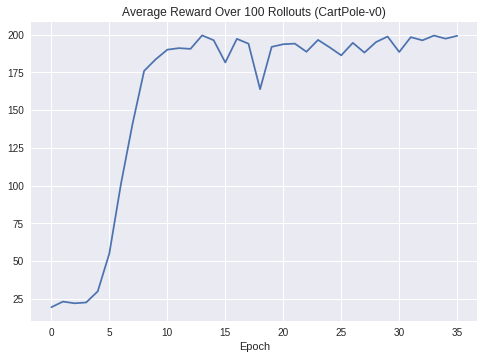

In [0]:
run_discrete('CartPole-v0', 195, 200)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Reward: 24.02, losses: value 244.08, policy -12.78, Hit max 0 times, recent avg 21.95:   0%|          | 2/1000 [00:02<19:52,  1.19s/it]

Reward: 197.20, losses: value 332.86, policy 0.15, Hit max 92 times, recent avg 151.03:   1%|          | 12/1000 [00:55<2:22:36,  8.66s/it]

Reward: 189.99, losses: value 95.79, policy -0.03, Hit max 61 times, recent avg 193.68:   2%|▏         | 22/1000 [03:10<3:30:39, 12.92s/it]

Reward: 198.95, losses: value 211.11, policy -0.05, Hit max 90 times, recent avg 198.81:   3%|▎         | 32/1000 [05:19<3:29:39, 12.99s/it]

Reward: 199.78, losses: value 283.82, policy 0.05, Hit max 99 times, recent avg 198.54:   4%|▎         | 37/1000 [06:22<3:21:53, 12.58s/it]

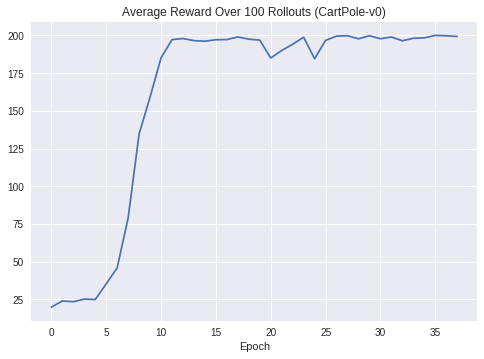

In [0]:
run_discrete('CartPole-v0', 199, 200)

## LunarLander-v2

### Earlier run (about 9:30pm-10:30pm)

I should have made sure I could get the 
plot displayed whether it finished on its own or not. It didn't look like it 
was going to converge by midnight, so I interrupted it to do another run.

In [0]:
run_discrete('LunarLander-v2', 200, 300)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Reward: -164.57, losses: value  2193.33, policy  0.28, Hit max  0 times:   0%|          | 2/1000 [00:13<1:53:44,  6.84s/it]

Reward: -119.85, losses: value  629.11, policy  0.29, Hit max  0 times:   1%|          | 12/1000 [01:23<2:00:46,  7.33s/it]

Reward: -34.36, losses: value  732.47, policy -0.19, Hit max  40 times:   2%|▏         | 22/1000 [04:21<6:12:27, 22.85s/it]

Reward:  68.62, losses: value  195.84, policy -0.04, Hit max  92 times:   3%|▎         | 32/1000 [10:05<9:35:57, 35.70s/it]

Reward:  114.28, losses: value  271.74, policy -0.03, Hit max  83 times:   4%|▍         | 42/1000 [16:05<9:23:39, 35.30s/it]

Reward:  111.42, losses: value  219.64, policy  0.02, Hit max  94 times:   5%|▌         | 52/1000 [21:59<9:18:33, 35.35s/it]

Reward:  138.05, losses: value  149.88, policy  0.03, Hit max  97 times:   6%|▌         | 62/1000 [28:04<9:35:25, 36.81s/it]

Reward:  157.09, losses: value  86.45, policy  0.04, Hit max  96 times:   7%|▋         | 72/1000 [34:12<9:20:51, 36.26s/it]

Reward:  145.23, losses: value  124.42, policy  0.02, Hit max  93 times:   8%|▊         | 82/1000 [40:05<9:01:00, 35.36s/it]

Reward:  160.56, losses: value  100.80, policy -0.00, Hit max  95 times:   9%|▉         | 92/1000 [46:01<8:57:17, 35.50s/it]

Reward:  171.30, losses: value  51.46, policy  0.02, Hit max  98 times:  10%|█         | 102/1000 [51:51<8:54:15, 35.70s/it]

Reward:  138.53, losses: value  369.84, policy  0.12, Hit max  80 times:  11%|█         | 112/1000 [57:40<8:19:15, 33.73s/it]

Reward:  172.65, losses: value  26.47, policy -0.01, Hit max  99 times:  12%|█▏        | 122/1000 [1:03:31<8:33:10, 35.07s/it]

Reward:  173.51, losses: value  74.97, policy -0.05, Hit max  96 times:  12%|█▎        | 125/1000 [1:05:42<8:17:59, 34.15s/it]

KeyboardInterrupt: ignored

### Try again (lower max_trial_time also) WE WIN

Lowering the maximum trial length to 250 was a really good idea. The epochs are about eight seconds faster, and it seems to also be learning a bit faster with respect to the number of epochs. 

I can't say for sure if it's learning faster with respect to the number of epochs, though, since the average at each epoch is somewhat variable, and I didn't have that displaying in my tqdm loop on the previous run.

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Reward: -189.67, losses: value 2227.83, policy -0.41, Hit max 0 times, recent avg -180.39:   0%|          | 2/1000 [00:13<1:55:31,  6.95s/it]

Reward: -112.25, losses: value 542.67, policy 0.15, Hit max 0 times, recent avg -136.56:   1%|          | 12/1000 [01:27<2:10:55,  7.95s/it]

Reward: -4.24, losses: value 642.18, policy -8.27, Hit max 48 times, recent avg -39.64:   2%|▏         | 22/1000 [04:35<5:35:53, 20.61s/it]

Reward: 106.25, losses: value 72.80, policy 0.02, Hit max 98 times, recent avg 101.34:   3%|▎         | 32/1000 [08:58<7:10:07, 26.66s/it]

Reward: 117.92, losses: value 137.42, policy 0.00, Hit max 96 times, recent avg 119.56:   4%|▍         | 42/1000 [13:31<7:16:51, 27.36s/it]

Reward: 151.51, losses: value 53.16, policy -0.02, Hit max 99 times, recent avg 139.53:   5%|▌         | 52/1000 [18:02<7:07:48, 27.08s/it]

Reward: 160.03, losses: value 125.35, policy -0.02, Hit max 94 times, recent avg 153.89:   6%|▌         | 62/1000 [22:27<6:59:31, 26.84s/it]

Reward: 154.48, losses: value 222.51, policy 0.06, Hit max 89 times, recent avg 161.31:   7%|▋         | 72/1000 [26:56<6:48:32, 26.41s/it]

Reward: 161.81, losses: value 89.95, policy 0.06, Hit max 97 times, recent avg 156.14:   8%|▊         | 82/1000 [31:31<6:53:42, 27.04s/it]

Reward: 160.98, losses: value 120.08, policy 0.02, Hit max 96 times, recent avg 156.89:   9%|▉         | 92/1000 [36:09<6:55:27, 27.45s/it]

Reward: 149.84, losses: value 223.32, policy -0.05, Hit max 95 times, recent avg 146.80:  10%|█         | 102/1000 [40:31<6:24:42, 25.70s/it]

Reward: 145.50, losses: value 365.26, policy 0.16, Hit max 88 times, recent avg 147.65:  11%|█         | 112/1000 [44:54<6:25:46, 26.07s/it]

Reward: 171.12, losses: value 39.74, policy 0.00, Hit max 99 times, recent avg 166.22:  12%|█▏        | 122/1000 [49:24<6:38:24, 27.23s/it]

Reward: 161.93, losses: value 142.97, policy 0.03, Hit max 92 times, recent avg 164.54:  13%|█▎        | 132/1000 [53:52<6:31:43, 27.08s/it]

Reward: 209.97, losses: value 634.70, policy -0.04, Hit max 55 times, recent avg 181.74:  14%|█▍        | 142/1000 [58:21<6:17:08, 26.37s/it]

Reward: 214.57, losses: value 548.66, policy -0.08, Hit max 49 times, recent avg 197.30:  14%|█▍        | 144/1000 [59:11<6:04:51, 25.57s/it]

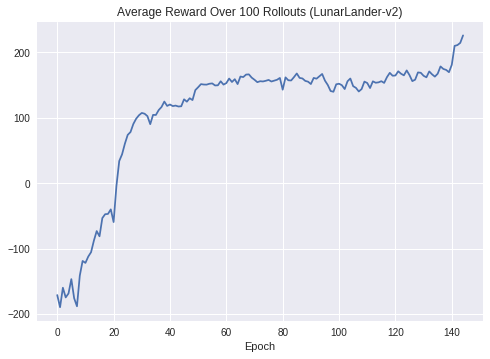

In [0]:
avg_rewards = []
run_discrete('LunarLander-v2', 200, 250, avg_rewards)